In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
service = QiskitRuntimeService(instance='ibm-q/open/main')
backends = service.backends()
print(backends)

NameError: name 'QiskitRuntimeService' is not defined

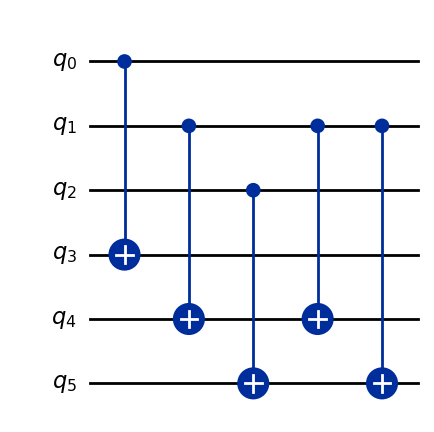

In [2]:
#pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
from qiskit_textbook.tools import simon_oracle

s = '110'
simon_oracle(s).draw('mpl')

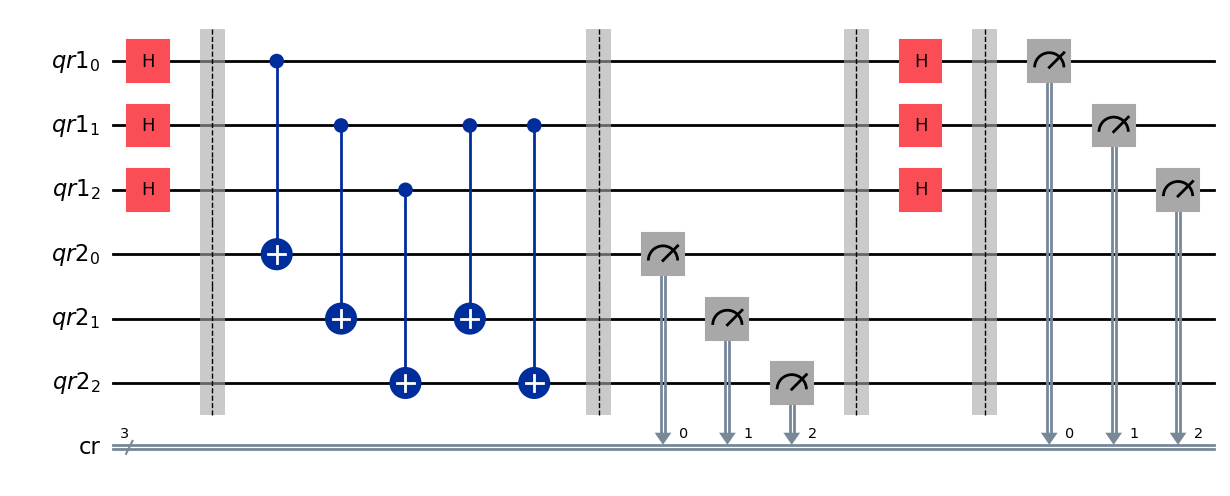

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

s = '110'
n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')
qc = QuantumCircuit(qr1, qr2, cr)

qc.h(qr1)
qc.barrier()

# copying the data of first register to second register
qc.cx(qr1, qr2)
# applying bit wise X-OR from register 1 to register 2 where qubits of first register is 1
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
qc.barrier()

qc.measure(qr2, cr)
qc.barrier()

qc.h(qr1)
qc.barrier()

qc.measure(qr1, cr)

qc.draw('mpl')

C:\Users\szaro\AppData\Local\Temp\ipykernel_29460\569822248.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = sim.run(job).result()


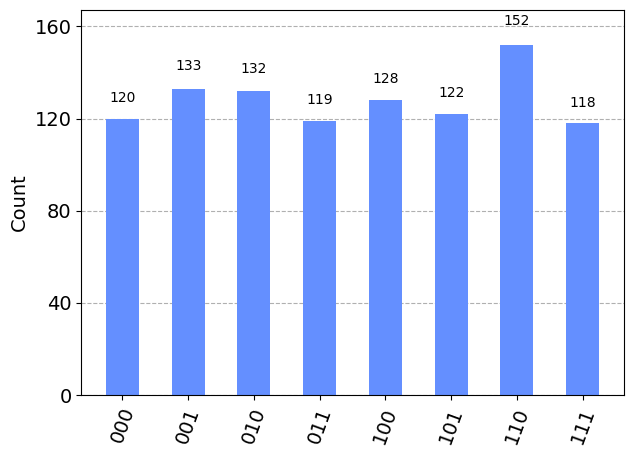

In [32]:
from qiskit_aer import QasmSimulator
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram

sim = QasmSimulator()
job = assemble(qc, sim)
result = sim.run(job).result()
counts = result.get_counts()
plot_histogram(counts)

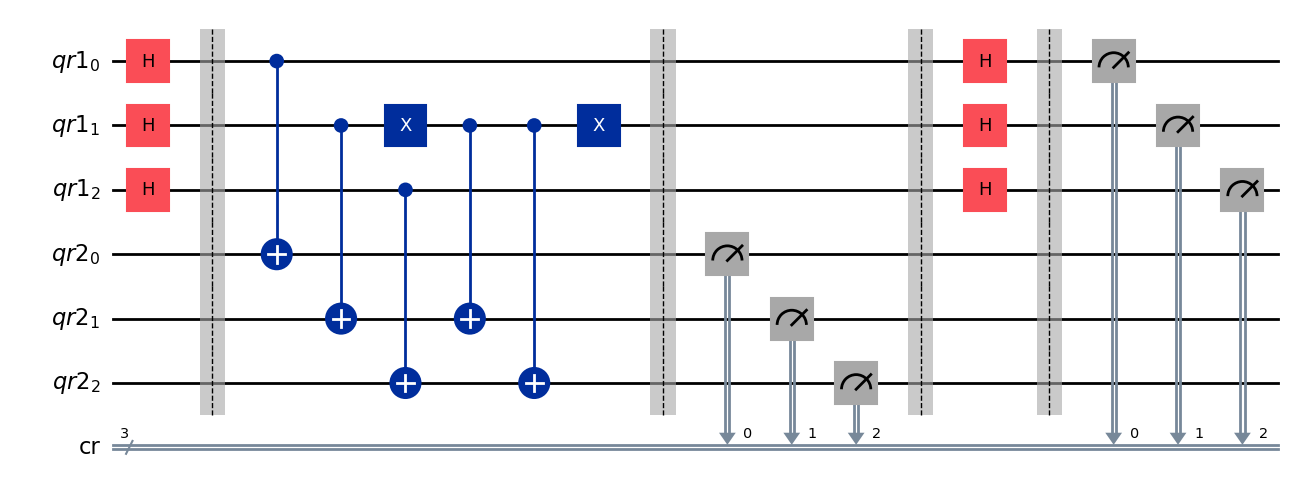

In [27]:
#a different way of implementing the oracle with X gates
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

s = '110'
n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')
qc = QuantumCircuit(qr1, qr2, cr)

qc.h(qr1)
qc.barrier()

# copying the data of first register to second register
qc.cx(qr1, qr2)
# applying bit wise X-OR from register 1 to register 2 where qubits of first register is 1
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
        qc.x(qr1[firstOne])
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
if firstOne != -1:
    qc.x(qr1[firstOne])
qc.barrier()

qc.measure(qr2, cr)
qc.barrier()

qc.h(qr1)
qc.barrier()

qc.measure(qr1, cr)

qc.draw('mpl')

C:\Users\szaro\AppData\Local\Temp\ipykernel_29460\569822248.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = sim.run(job).result()


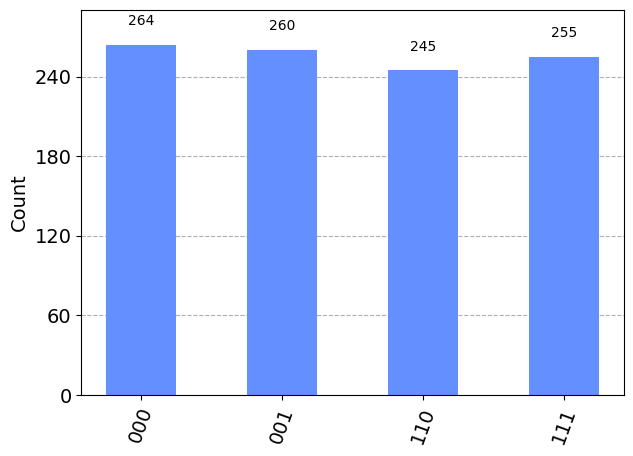

In [28]:
from qiskit_aer import QasmSimulator
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram

sim = QasmSimulator()
job = assemble(qc, sim)
result = sim.run(job).result()
counts = result.get_counts()
plot_histogram(counts)